# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from yellowbrick.classifier import ROCAUC
from sklearn.decomposition import PCA

sys.path.insert(0, r"d:\ML\Fake News Detection")
from src.data_audit import DataAudit


## Loading data

In [15]:
PATH_TO_DATA = r"d:\ML\Fake News Detection\data\liar_processed.csv"
data = pd.read_csv(PATH_TO_DATA)
data

,label,statement,party_affiliation,barely_true,false,half_true,mostly_true,speaker_length,job_title_length,state_category,total_history,truth_index,context_group,statement_length,proper_nouns,adjectives,other,lexical_diversity
0,1,Says the Annies List political group supports ...,republican,0.0,0.0,0.0,0.0,12,20.0,texas,0.0,0.000000,campaign_ads,82,0.166667,0.083333,0.166667,1.000000
1,3,When did the decline of coal start? It started...,democrat,0.0,0.0,0.0,1.0,14,14.0,other,1.0,0.400000,live,141,0.142857,0.035714,0.321429,0.928571
2,4,"Hillary Clinton agrees with John McCain ""by vo...",democrat,70.0,71.0,160.0,162.0,12,9.0,illinois,472.0,0.566173,other,105,0.318182,0.000000,0.272727,0.954545
3,1,Health care reform legislation is likely to ma...,other,7.0,18.0,3.0,5.0,12,NaN,other,77.0,0.156410,official,78,0.076923,0.153846,0.153846,1.000000
4,3,The economic turnaround started at the end of ...,democrat,15.0,9.0,19.0,19.0,13,NaN,florida,64.0,0.529231,broadcast,54,0.000000,0.090909,0.272727,0.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12786,3,Says his budget provides the highest state fun...,republican,28.0,23.0,37.0,34.0,10,8.0,florida,129.0,0.501538,live,82,0.000000,0.071429,0.142857,1.000000
12787,2,Ive been here almost every day.,democrat,1.0,0.0,0.0,1.0,9,8.0,other,2.0,0.400000,broadcast,31,0.142857,0.000000,0.285714,1.000000
12788,2,"In the early 1980s, Sen. Edward Kennedy secret...",other,0.0,0.0,0.0,0.0,21,48.0,other,0.0,0.000000,other,147,0.173913,0.130435,0.260870,0.956522
12789,2,Says an EPA permit languished under Strickland...,republican,8.0,8.0,10.0,18.0,11,36.0,ohio,47.0,0.525000,live,96,0.157895,0.052632,0.157895,0.947368


## Experiment

We will first try the statement column and trying to vectorize it

In [16]:
predictions = len(data) * [3]
accuracy = accuracy_score(data['label'], predictions)
precision = precision_score(data['label'],
                            predictions,
                            average='weighted',
                            zero_division=0)
recall = recall_score(data['label'],
                      predictions,
                      average='weighted',
                      zero_division=0)
f1 = f1_score(data['label'], predictions, average='weighted', zero_division=0)
report = []
report.append({
    "model": "Baseline(predicting the most common class)",
    "alpha": None,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

In [17]:
def calculate_metrics(y_true, y_pred, model_name, alpha=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    report.append({
        "model": model_name,
        "alpha": alpha,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

In [18]:
def save_to_excel(report, filename='naive_bayes_report.xlsx'):
    df_report = pd.DataFrame(report)
    df_report.to_excel(filename, index=False)

In [19]:
for alpha in [0.005, 0.1, 0.5, 1.0, 2, 5, 10]:
    pipeline = Pipeline([('vectorizer', TfidfVectorizer()),
                         ('classifier', MultinomialNB(alpha=alpha))])
    X_train, X_test, y_train, y_test = train_test_split(data['statement'],
                                                        data['label'],
                                                        test_size=0.2,
                                                        random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    calculate_metrics(y_test,
                      y_pred,
                      model_name="Naive Bayes with TfidfVectorizer",
                      alpha=alpha)
    pipeline = Pipeline([('vectorizer', CountVectorizer()),
                         ('classifier', MultinomialNB(alpha=alpha))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    calculate_metrics(y_test,
                      y_pred,
                      model_name="Naive Bayes with CountVectorizer",
                      alpha=alpha)


In [20]:
X = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [21]:
def grid_search_naive_bayes(X_train, y_train, pipeline):
    param_grid = {
        'classifier__alpha': [0.005, 0.1, 0.5, 1.0, 2, 5, 10, 15]
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=5,
                               scoring='f1_weighted',
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

In [22]:
text_col = 'statement'
categorical_cols = X_train.select_dtypes(include=['object']).columns.drop(text_col)
numerical_cols = X_train.select_dtypes(include=np.number).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), text_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

In [ ]:
best_model_all_features = grid_search_naive_bayes(X_train, y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test)
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with All Features",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])
best_model_all_features = grid_search_naive_bayes(X_train.drop(columns = ['statement']), y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test.drop(columns = ['statement']))
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with All Features without statement",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

We can see a little higher f1 might be strange but we must try some more columns

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[numerical_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[numerical_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with All Numerical Features",
                  alpha=best_model_all_features[1]['classifier__alpha'])

print(report[-1]["f1"])

In [ ]:
selected_cols = ['barely_true', 'false', 'half_true', 'mostly_true']
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), selected_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with Initial Numerical Features",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

In [ ]:
selected_cols = ['context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), selected_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with Initial Categorical Features",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

Seems that categorical features bring us more than numeric, which is expected, because the classifier should work better with discreet, not continuous values. So let us try the categorical columns with  vectorization

In [ ]:
selected_cols = ['context_group', 'state_category', 'party_affiliation', 'statement']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with Initial Categorical Features including statement",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

Looks like the score is lower this way. We should try using n-grams

In [ ]:
selected_cols = ['statement']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(stop_words='english', ngram_range=(1, 2)), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with only statement removing stopwords and 2-grams",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

Not great results, but let us dive deeper with what we can add

In [ ]:
selected_cols = ['statement']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', ngram_range=(1, 2)), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with only statement removing stopwords and 2-grams using TF-IDF",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

Here we see a little better results, maybe we should try stemming?

In [31]:
def stemmed_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [ ]:
selected_cols = ['statement']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(tokenizer=stemmed_tokenizer, stop_words='english', ngram_range=(1, 2)), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with only statement removing stopwords and 2-grams using TF-IDF and stemming",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

A little better result, we will try with CountVectorizer

In [ ]:
selected_cols = ['statement']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(tokenizer=stemmed_tokenizer, stop_words='english', ngram_range=(1, 2)), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with only statement removing stopwords and 2-grams using CountVectorizer and stemming",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

This may be better, let us try again with the categorical columns

In [34]:
selected_cols = ['statement', 'context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(tokenizer=stemmed_tokenizer, stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with only statement removing stopwords and 2-grams using CountVectorizer and stemming",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

0.25906266551542095


It looks like the statement is not really useful, we should try limiting the number of words

In [35]:
selected_cols = ['statement', 'context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(tokenizer=stemmed_tokenizer, max_features=100, stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with statement, context_group, state_category, and party_affiliation removing stopwords and 2-grams using CountVectorizer and stemming with max_features=100",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

0.26184039260001796


100 words doesnt work for us, maybe we should limit to 1000

In [36]:
selected_cols = ['statement', 'context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(tokenizer=stemmed_tokenizer, max_features=1000, stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns removing stopwords and 2-grams using CountVectorizer and stemming with max_features=100",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

0.2620720238872153


We see an improvement here, let us find the best param using grid search

In [ ]:
def grid_search_naive_bayes(X_train, y_train, pipeline):
    param_grid = {
        'classifier__alpha': [0.005, 0.1, 0.5, 1.0, 2, 5, 10, 15],
        'preprocessor__text__max_features': [50, 100, 200, 500, 1000, 1500, 2000]
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=5,
                               scoring='f1_weighted',
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

In [38]:
selected_cols = ['statement', 'context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(tokenizer=stemmed_tokenizer, max_features=1000, stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns removing stopwords and 2-grams using CountVectorizer and stemming with searching for best max_features",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

0.2605788015664612


In [39]:
def grid_search_naive_bayes(X_train, y_train, pipeline):
    param_grid = {
        'classifier__alpha': [0.005, 0.1, 0.5, 1.0, 2, 5, 10, 15],
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

Worse f1 score, we will try to use the other numerical columns to the categorical columns.

In [40]:
print(len(report))

29


In [41]:
data.dropna(subset = ['truth_index'], inplace=True)
X = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

                                            

In [42]:

selected_cols = ['context_group', 'state_category', 'party_affiliation', 'truth_index']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation']),
        ('num', 'passthrough', ['truth_index'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns including truth_index",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

0.26408025433755405


We got a little worse result.

In [43]:

selected_cols = ['context_group', 'state_category', 'party_affiliation', 'statement_length']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation']),
        ('num', 'passthrough', ['statement_length'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns including statement_length",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

0.260154907451056


Doesnt help us either.

In [44]:

selected_cols = ['context_group', 'state_category', 'party_affiliation', 'false']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation']),
        ('num', 'passthrough', ['false'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns including false news column",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

0.23258243677847776


In [ ]:

selected_cols = ['context_group', 'state_category', 'party_affiliation', 'adjectives']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation']),
        ('num', 'passthrough', ['adjectives'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns including adjectives",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

Adjectives boost our result a little.

In [ ]:

selected_cols = ['context_group', 'state_category', 'party_affiliation', 'adjectives', 'proper_nouns', 'other']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation']),
        ('num', 'passthrough', ['adjectives', 'proper_nouns', 'other'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns including adjectives, proper_nouns, and other",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

Again not the result we all expected... Should try lexical diversity


In [ ]:

selected_cols = ['context_group', 'state_category', 'party_affiliation', 'lexical_diversity']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation']),
        ('num', 'passthrough', ['lexical_diversity'])
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', MultinomialNB())])

best_model_all_features = grid_search_naive_bayes(X_train[selected_cols], y_train, pipeline)
y_pred = best_model_all_features[0].predict(X_test[selected_cols])
calculate_metrics(y_pred,
                  y_test,
                  model_name="Naive Bayes with cat columns including lexical_diversity",
                  alpha=best_model_all_features[1]['classifier__alpha'])
print(report[-1]["f1"])

We will pick the best model that uses statement, just to show what is the importance of the column

In [81]:
selected_cols = ['statement', 'context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer( transformers=[ ('text', CountVectorizer(), 'statement'),
                                                 ('cat', OneHotEncoder(handle_unknown='ignore'), ['context_group', 'state_category', 'party_affiliation']) ], 
remainder='drop' ) 
pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', MultinomialNB(alpha=5))])
pipeline.fit(X_train[selected_cols], y_train) 
y_pred = pipeline.predict(X_test[selected_cols])


In [ ]:
# save_to_excel(report)

AttributeError: 'float' object has no attribute 'show'

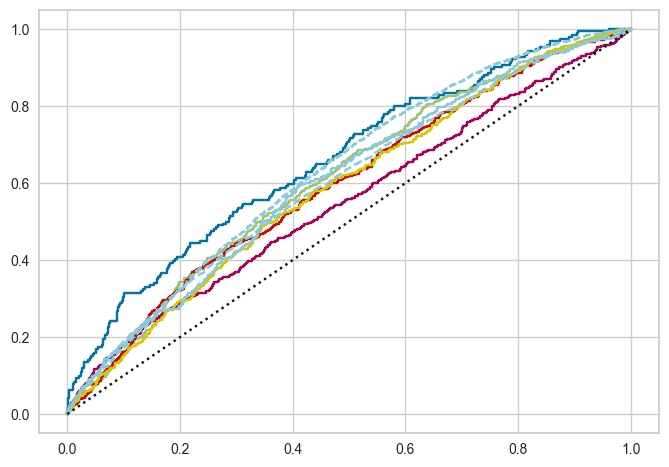

In [82]:
visualizer = ROCAUC(pipeline, classes=['False', 'Half-True', 'Mostly-True', 'True', 'Barely-True', 'Pants-on-Fire']).fit(X_train, y_train).score(X_test, y_test).show()

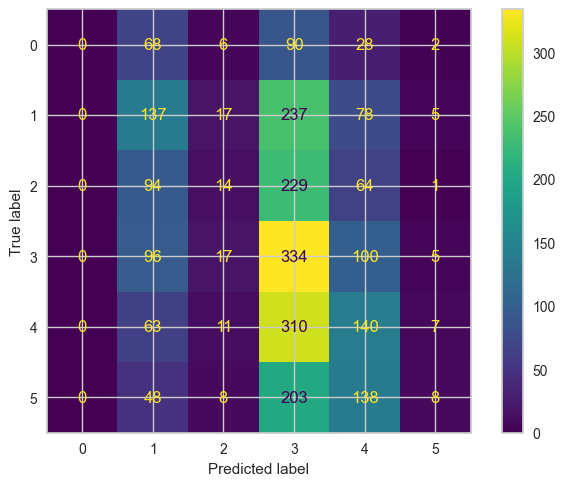

In [83]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()